In [1]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
color = 'rgb' #'grayscale' o 'rgb'
batch = 32
escala = 150
test = 'iphone'

In [9]:
def combine_generator(gen1, gen2):
    while True:
        tupla1 = next(gen1)
        tupla2 = next(gen2)
        
        array_img_1 = tupla1[0]
        array_labels_1 = tupla1[1]
        
        array_img_2 = tupla2[0]
        array_labels_2 = tupla2[1]
        
        arrays_img = np.concatenate((array_img_1,array_img_2))
        arrays_labels = np.concatenate((array_labels_1,array_labels_2))
        
        yield(tuple((arrays_img,arrays_labels)))

In [10]:
datagen = ImageDataGenerator(rotation_range=10, # rotation
                                width_shift_range=0.2, # horizontal shift
                                height_shift_range=0.2, # vertical shift
                                zoom_range=0.2, # zoom
                                horizontal_flip=True, # horizontal flip
                                brightness_range=[0.2,1.2], # brightness
                                rescale = 1./255,
                                validation_split = 0.2)

In [17]:
train_generator = datagen.flow_from_directory(directory="Datos INP EMD/OCT",
                                              target_size=(escala, escala), # resize to this size
                                              color_mode=color, # for coloured images
                                              batch_size = 1024,
                                              seed=42, # to make the result reproducible 
                                              subset='training')

Found 91 images belonging to 2 classes.


In [18]:
val_generator = datagen.flow_from_directory(
                  directory="Datos INP EMD/OCT",
                  target_size=(escala, escala), # resize to this size
                  color_mode=color, # for coloured images
                  seed=42, # to make the result reproducible
                  batch_size = 1024,
                  subset='validation')

Found 22 images belonging to 2 classes.


In [23]:
test_datagen = ImageDataGenerator(rotation_range=10, # rotation
                                width_shift_range=0.2, # horizontal shift
                                height_shift_range=0.2, # vertical shift
                                zoom_range=0.2, # zoom
                                horizontal_flip=True, # horizontal flip
                                brightness_range=[0.2,1.2], # brightness
                                rescale = 1./255)

In [38]:
 if (test=='iphone'):
    test_generator = test_datagen.flow_from_directory(
            directory = 'Datos INP EMD/iPhone',
            target_size = (escala,escala),
            color_mode = color,
            shuffle = False,
            class_mode='categorical',
            batch_size=1024,
            seed = 42)

else:
    test_generator = test_datagen.flow_from_directory(
            directory = 'Datos INP EMD/Samsung',
            target_size = (escala,escala),
            color_mode = color,
            shuffle = False,
            class_mode='categorical',
            batch_size=1024,
            seed = 42)


Found 99 images belonging to 2 classes.


### TRAIN: OCT + Samsung

### TEST: iPhone

In [39]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_generator.image_shape)
base_model.trainable = False ## Not trainable weights

In [40]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='Ftrl',
    loss='kl_divergence',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_generator, batch_size=batch, epochs=200, callbacks=[es], validation_data=val_generator)

Epoch 1/200
1/1 [==============================] - 12s 12s/step - loss: 0.5110 - accuracy: 0.8242 - val_loss: 0.6925 - val_accuracy: 0.8636
Epoch 2/200
1/1 [==============================] - 9s 9s/step - loss: 0.6926 - accuracy: 0.8352 - val_loss: 0.6920 - val_accuracy: 0.8636
Epoch 3/200
1/1 [==============================] - 9s 9s/step - loss: 0.6921 - accuracy: 0.8352 - val_loss: 0.6916 - val_accuracy: 0.8636
Epoch 4/200
1/1 [==============================] - 9s 9s/step - loss: 0.6917 - accuracy: 0.8352 - val_loss: 0.6912 - val_accuracy: 0.8636
Epoch 5/200
1/1 [==============================] - 9s 9s/step - loss: 0.6914 - accuracy: 0.8352 - val_loss: 0.6909 - val_accuracy: 0.8636
Epoch 6/200
1/1 [==============================] - 9s 9s/step - loss: 0.6911 - accuracy: 0.8352 - val_loss: 0.6906 - val_accuracy: 0.8636
Epoch 7/200
1/1 [==============================] - 9s 9s/step - loss: 0.6908 - accuracy: 0.8352 - val_loss: 0.6903 - val_accuracy: 0.8636
Epoch 8/200
1/1 [===============

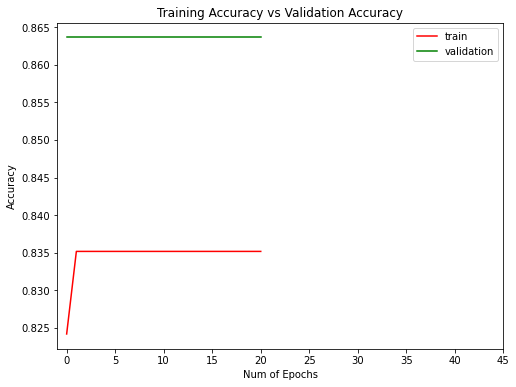

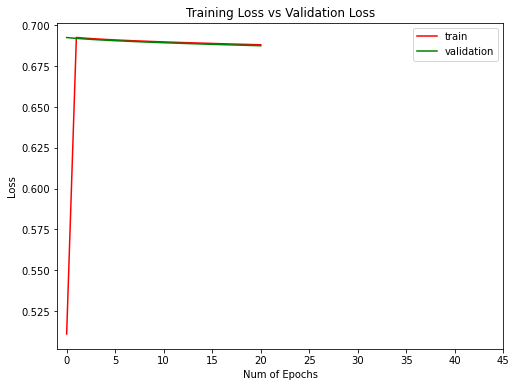

In [43]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

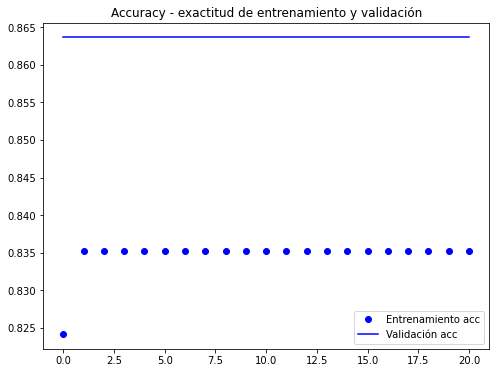

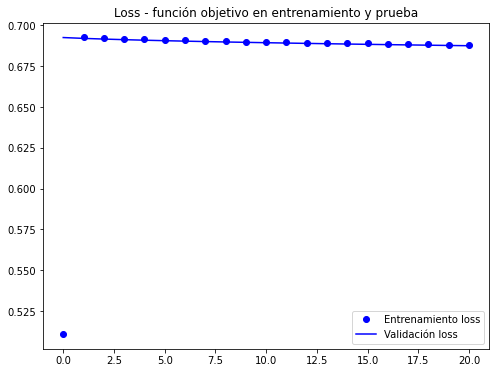

In [44]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [45]:
y_test = test_generator.classes
    
predictions = model.predict(test_generator)
y_pred = list(map(lambda x: list(x).index(max(x)),predictions))

vgg_cm = confusion_matrix(y_test, y_pred)

1/1 [==============================] - 8s 8s/step


In [46]:
vgg_cm

array([[ 0, 24],
       [ 0, 75]], dtype=int64)

In [47]:
roc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print(roc_score)

0.5


In [49]:
f_score = f1_score(y_true =y_test, y_pred = y_pred, average = 'weighted')

print(f_score)

0.6530825496342737
